# **Classification**

## **Datasets**

*sklearn.datasets* package contains three types of functions:
1) fetch_* : download real life datsets
2) load_* : load small toy datasets bundled with Scikit-Learn returns "data", "target", "DESCR"
3) make_* : generate fake datasets returned as an Numpy array of (X,y)

In [79]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame=False)
X,y = mnist.data,mnist.target

In [80]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [81]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

the default return is pandas but using as_frame = False gives numpy arrays

In [82]:
X.shape,y.shape

((70000, 784), (70000,))

70000 images and 784 features each(28x28 pixels)

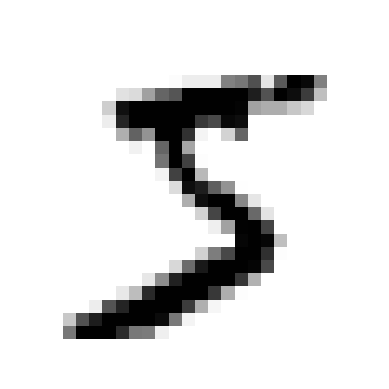

5


In [83]:
import matplotlib.pyplot as plt
def display_image(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image,cmap="binary")
    plt.axis("off")

some_digit = X[0]
display_image(some_digit)
plt.show()
print(y[0])

In [84]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

## **Train a binary classifier**

Let's train a simple model that distinguishes between two classes 

In [85]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

SGDClassifier is capable of handling large datasets efficiently, this is partly because SGD deals with training instances independently one at a time, which also makes SGD well suited for online learning

In [86]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [87]:
sgd_clf.predict([some_digit])

array([ True])

## **Performance Measures**



### **Measuring accuracy using cross validation**

cross-validation is a good measure especially when working with a smaller datasets, it divides the dataset into k folds, trains the model on k-1 folds and tests on kth fold and repeats for all combinations(k is controlled using cv=)

In [88]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

the accuracy it shows is pretty good, but we only trained the model on deciding wether it is 5 or not

In [89]:
j=0
for i in y_train:
    if i=='5':
        j+=1
print(j)

5421


5421 occurences of 5 out of 60,000 that is nearly 10% so even if our model was to guess not 5 times it will be accurate 90% of the times, which shows that accuracy is not always the best performance measure

### **Confusion Matrices**
Confusion matrix forms a 2d matrix with rows and columns representing our classes and shows A/B predictions where instances of Class A are classified as instances of Class B, we can play around with it and print number of such instances, percentages on the basis of number of occurences of instances, total instances etc. color code it your preference as well

But first we need predictions, for that we can use *cross_val_predict* similar to the *cross_val_score* instead of giving a score it gives us the prediction

In [90]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
cm = confusion_matrix(y_train_5,y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

How to interpret the confusion matrix?
the first row and column represents negative(non-5 images), while the second row and column represent the positive class(5 image), so 
1) 53892 is the number of time non-5 images were predicted to be non 5-image    : TN
2) 687 is the number of non-5 images predicted to be 5 image                    : FP
3) 1891 is the number of 5 image predicted to be non-5 image                    : FN
4) 3530 is the number of 5 image predicted to be 5 image                        : TP

>Precision: TP/(TP+FP)

>Recall: TP/(TP+FN)

In [91]:
from sklearn.metrics import precision_score,recall_score
print("precision :",precision_score(y_train_5,y_train_pred))
print("recall :",recall_score(y_train_5,y_train_pred))

precision : 0.8370879772350012
recall : 0.6511713705958311


>F1 Score: 2 x ((Precision*Recall)/(Precision+Recall))

In [92]:
from sklearn.metrics import f1_score
print("f1 score :",f1_score(y_train_5,y_train_pred))

f1 score : 0.7325171197343847


Precision, Recall or F1 score there is no fit all approach, it is dependent on the application what do you want high precision, high recall or a well-balanced f1 score

### **Precision/Recall Tradeoff**

Let's take the example of SGDClassifier, it finds a threshold and a function, when it inputs the value in the function if the value is greater than the threshold it is classified as positive class and if not then it is classified as negative, the image attached below shows it

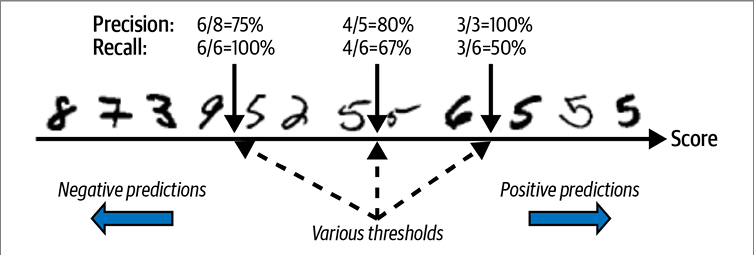



although you cannot explicitly set the threshold we can access the decision function of the SGDClassifier and can set conditions to check threshold manually for classification

In [93]:
print(sgd_clf.decision_function([some_digit]))

[2164.22030239]


In [94]:
threshold = 0
print(sgd_clf.decision_function([some_digit])<threshold)

[False]


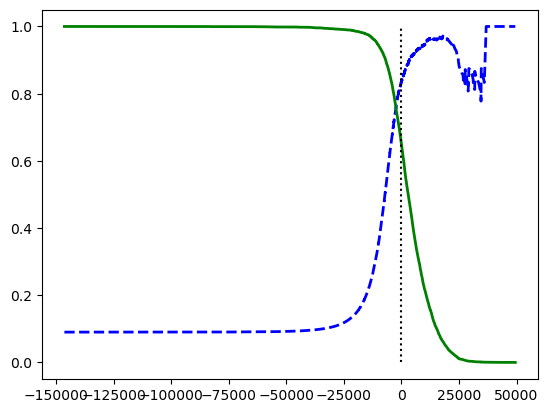

In [95]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)
plt.plot(thresholds,precisions[:-1],"b--",label="Precision",linewidth=2)
plt.plot(thresholds,recalls[:-1],"g-",label="Recall",linewidth=2)
plt.vlines(threshold,0,1.0,"k","dotted",label="threshold")
plt.show()

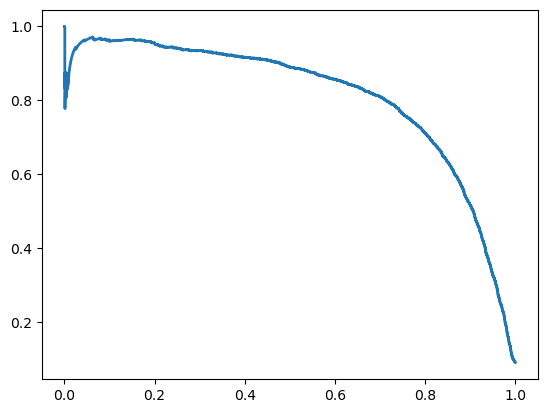

In [96]:
plt.plot(recalls,precisions,linewidth=2,label="Precision/Recall Curve")
plt.show()

In [97]:
idx_for_90_precision = (precisions>=0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

if we were to set our threshold to 3370 we will get a 90% precision but what about recall?

In [98]:
y_train_pred_90 = (y_scores>=threshold_for_90_precision)
print("Precision: ",precision_score(y_train_5,y_train_pred_90))
print("Recall :",recall_score(y_train_5,y_train_pred_90))

Precision:  0.9000345901072293
Recall : 0.4799852425751706


From all the above we realize that precision and recall don't increase simultaneously there is a tradeoff that needs to be made, which to choose that will depend upon your use case

#### Precision
Precision measures the proportion of **correct positive predictions** out of all predictions made as positive. It answers the question: *"Out of all the predictions I made as positive, how many were actually correct?"*


#### Recall
Recall measures the proportion of **actual positives** that the model correctly identified. It answers the question: *"Out of all the actual positives, how many did I correctly remember (predict)?"*


#### Intuitive Example
Let’s assume we’re building a model to detect spam emails:
- **Precision:** Of all the emails the model flagged as spam, how many were actually spam?
- **Recall:** Of all the actual spam emails, how many did the model successfully identify?

#### Key Takeaway:
- **Precision:** Focuses on the quality of positive predictions.
- **Recall:** Focuses on the completeness of positive predictions.

#### Trade-off
There is often a trade-off between precision and recall. For example:
- Increasing **precision** might reduce **recall**, as the model becomes stricter in declaring something positive.
- Increasing **recall** might reduce **precision**, as the model starts predicting more positives, including false positives.

These are crucial metrics in classification tasks, especially for imbalanced datasets or when the cost of false positives/negatives differs.

### **ROC Curve**

*Return Operating Curve* is a common tool used with binary classifiers it plots True Positive Rate(Recall) on y axis vs False Positive Rate(FP/TN+FP) on x axis

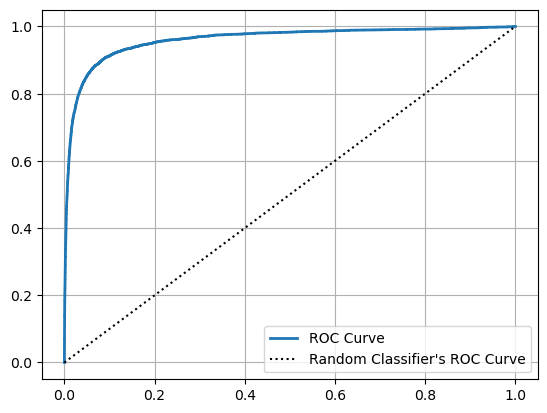

In [99]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)
plt.plot(fpr,tpr,linewidth=2,label="ROC Curve")
plt.plot([0,1],[0,1],'k:',label="Random Classifier's ROC Curve")
plt.legend()
plt.grid()
plt.show()

How to compare classifiers?

Compare the AUC, good classifiers have an AUC almost equal to 1.0

Try to remain away from the dotted line

While the ROC curve is useful for balanced datasets, the Precision-Recall (PR) curve may be more informative for imbalanced datasets, as it focuses more directly on the positive class.

## **MultiClass Classification**

*LogisticRegression*,*RandomForestClassifier*,*GaussianNB* are capable of handling multiple classes natively, others such as the *SGDClassifier* and *SVC* are strictly binary classifiers there are two strategies to make them multiclass classifier OvO(one-versus-one) or OvR(one-versus-rest). 

SVC scale poorly for large datasets therfore making OvO is the best option while for others OvR is the better option

Scikit-learn detects when you try to train a binary classification method for a multiclass classification it automatically runs an OvO or OvR strategy

In [100]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000])
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(some_digit_scores.argmax())
print(svm_clf.classes_)

[[ 3.79297828  0.72949369  6.06184129  8.29800527 -0.29383983  9.30157597
   1.74723215  2.77365456  7.20601456  4.82245092]]
5
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Scikit-learn upon seeing the use of SVC for multiclass classification automatically runs an OvO strategy, that is it trains 45 binary classifiers comparing two classes, we can see using the *decision_function* the scores of its duels against other classes the highest one is the final classification, also *classes_* stores the classes SVC is trained upon

It is also possible to forcefully train a OvO or OvR classifier by using *OneVsOneClassifier* or *OneVsRestClassifier* classes from sklearn.multiclass

In [101]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000],y_train[:2000])
print(ovr_clf.predict([some_digit]))
print(ovr_clf.classes_)

['5']
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [102]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train)
print(sgd_clf.predict([some_digit]))
print(sgd_clf.decision_function([some_digit]))

['3']
[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


The result it shows is not correct, let's check the accuracy of the model

In [103]:
print(cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy"))

[0.87365 0.85835 0.8689 ]


In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy"))

[0.8983 0.891  0.9018]


using only two more lines of codes we improved the accuracy

## **Error Analysis**
The steps of a project lifecycle begins with taking a look at the data, prepare the data, train multiple models, shortlist the best ones, fine tune their parameters and automate as much as possible. Let's assume you found a good model and you want to find ways to improve it that's where error analysis comes in. 

Usually, the first step is to get predictions using *cross_val_predict* and then pass them to *confusion_matrix* to see where are the errors coming from, we use ConfusionMatrixDisplay instead of confusion_matrix as we are trying to see the difference between 10 classes and require a better visual

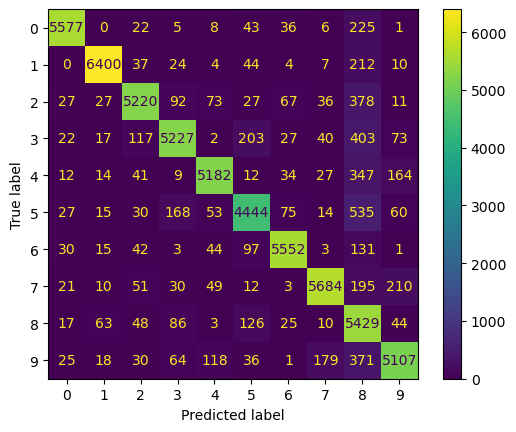

In [105]:
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred)
plt.show()

The result shows us number which can be read but are not that easy to interpret so there are several more ways to display them

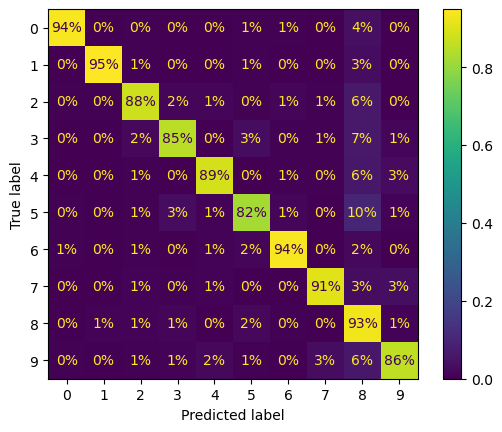

In [106]:
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize="true",values_format=".0%")
plt.show()

This divides the value in the cell by the sum of the row i.e. how many 5 were misclassified as 3 divided by total number of 5

Only 82% of 5 were correctly classified, 10% of the 5 were missclassified as 8 and all the other classes were also misclassified as 8 also

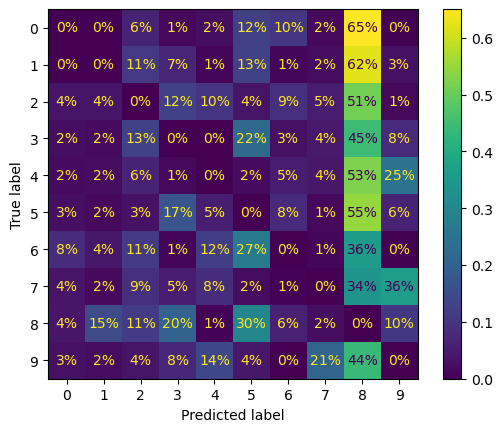

In [107]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,sample_weight=sample_weight,normalize="true",values_format=".0%")
plt.show()

Now it becomes even easier to see the errors, the sample_weight is the total number of misclassifications and we see the rows have the highest values for 8 ex 55% of row 5 and column 8 tells how many % of the misclassification of the class 5 were classified as 8

We can also use *ConfusionMatrixDisplay.from_estimator(sgd_clf,X_train_scaled,y_train)* it is concise but the above method uses CrossValidation which is a good practice

To increase accuracy we can:
1) Increase the dataset 
2) Increase number of instances which look like 8 but are not
3) Engineer new features which differentiate between number of closed loops, different type of loops
4) Augment the training data

## **Multilabel Classification**
The above examples classifies the instances into one class based on prediction scores, but there are many situations where we require instead to output multiple classes for each instance. ex: Face tagging software needs to give an output [True,False,False] in case you saved the name of 3 people to faces in your phones


In [108]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>='7')
y_train_odd = (y_train.astype('int8')%2==1)
y_multilabel = np.c_[y_train_large,y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

We first create a y_multilabel containing two arrays one with y values greater than 7 and one with y with odd values, the KNeighborsClassifier() trains a model on multilabel, some classifiers train multiple model based on output labels, while some such as Kneighbors and RandomForest can work it out with only one model

Evaluation of a Multilabel classifier is tricky, the measure is well dependent on the case you are working on, sometimes both label might cary equal weightage to the result whereas sometimes it might not be so, let's take f1 score for the above multilabel classifier

In [109]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average="macro")

0.9764102655606048

In [110]:
f1_score(y_multilabel,y_train_knn_pred,average="weighted")

0.9778357403921755

"macro" assusmes that each class is given equal weightage wheres "weighted" assumes that each class is given a weightage proportional to the amount of instances to total instances

Not all models support multilabel classification, a strategy is to train a model for each label but *it will not be able to learn the interdependencies* such as number greater than 7 there is higher probability of being odd

Scikit-learn has a solution for this which is the *ChainClassifier*: when a model makes a prediction, it uses all the input features as well as the predictions of the models that come before in its chain, capturing interdependencies

In [111]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(),cv=3,random_state=42)
chain_clf.fit(X_train,y_multilabel)
chain_clf.predict([some_digit])

array([[0., 1.]])

Normally, in a classifier chain, the predictions from earlier classifiers in the chain are directly used as features to train subsequent classifiers.

When cv is specified, the predictions for the earlier labels are replaced with out-of-fold predictions obtained via cross-validation. This ensures that the predictions used as features for training are not overly optimistic because they are derived from data unseen by the classifier during training.

Limitations:
- Computationally expensive
- Sensitive to label order; incorrect ordering might lead to suboptimal performance

## **Multioutput Classification**
Multioutput-Multiclass classification, the big boss of classification, what if we have a multilabel and each label instead of True or False returns another value?

an example would be we introduce noise to our mnist images and we want to clean and return us an image, when we convert image to numbers we get a 28x28 matrix and each cell contains a value between 0 and 255 (this is for grayscale, if you were to use RGB it will have 3 such values, and in vedios include a time element as well) so now we will have to return the same a 28x28 matrix each cell containing a value between 0 and 255

In [112]:
np.random.seed(42)
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

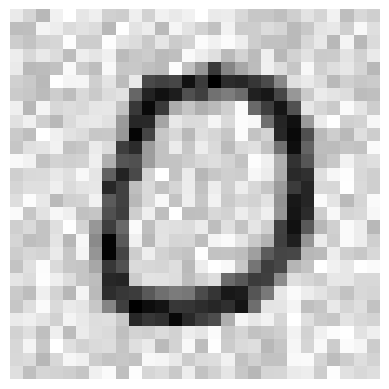

In [113]:
display_image(X_test_mod[10])
plt.show()

The above shows an image with noise

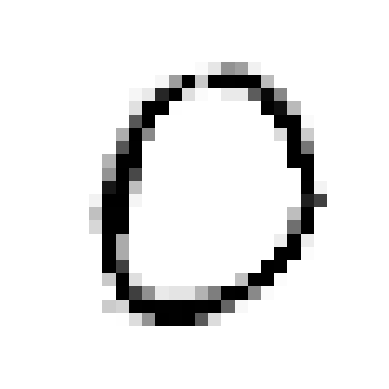

In [114]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[10]])
display_image(clean_digit)
plt.show()

# **Exercises**

 1) Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [115]:
print(y_test)

['7' '2' '1' ... '4' '5' '6']


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
params = {"weights":["distance","uniform"],
          "n_neighbors":[3,4,5,6,7,8]}
knn_clf = GridSearchCV(KNeighborsClassifier(),param_grid=params,cv=3,refit="True")
knn_clf.fit(X_train,y_train)
y_pred = knn_clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9714


2) Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.6\ Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

    You can use the shift() function from the scipy.ndimage.interpolation module. For example,
    shift(image, [2, 1], cval=0) shifts the image two pixels down and one pixel to the right.

In [ ]:
knn_clf = knn_clf.best_estimator_

In [126]:
from scipy.ndimage import shift
import numpy as np

def augment(X, y):
    X_augmented = list(X)  
    y_augmented = list(y)  
    
    for img, label in zip(X, y):
        img_2d = img.reshape(28, 28)  # Reshape to 2D (28x28)
        
        # Apply shifts on the 2D image and reshape to 1D (784)
        X_augmented.append(shift(img_2d, (1, 0)).reshape(784))   # Shift down
        y_augmented.append(label)
        X_augmented.append(shift(img_2d, (-1, 0)).reshape(784))  # Shift up
        y_augmented.append(label)
        X_augmented.append(shift(img_2d, (0, 1)).reshape(784))   # Shift right
        y_augmented.append(label)
        X_augmented.append(shift(img_2d, (0, -1)).reshape(784))  # Shift left
        y_augmented.append(label)
    
    # Convert the augmented data into numpy arrays
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    return X_augmented, y_augmented

# Assuming X_train and y_train are properly defined
X_train_augmented, y_train_augmented = augment(X_train, y_train)
knn_clf.fit(X_train_augmented, y_train_augmented)
y_pred = knn_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9763


3) Tackle the Titanic dataset. A great place to start is on Kaggle. Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files, train.csv and test.csv, which you can load using pandas.read_csv(). The goal is to train a classifier that can predict the Survived column based on the other columns.

In [40]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename) for filename in ("train.csv", "test.csv")]


In [41]:
train_data, test_data = load_titanic_data()  

In [42]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We will set PassengerId as the index explicitly, seperate Survived in as other numpy array, impute other values, drop Cabin,Ticket,Parch,SibSp and Name, impute numerical values using mean for categorical using most_frequent

In [44]:
print(train_data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data.columns = train_data.columns.str.strip()
train_data = train_data.set_index('PassengerId')
X_train = train_data.drop('Survived', axis=1).copy()
y_train = train_data['Survived'].copy()
X_train = train_data.drop(['Survived', 'Cabin', 'Ticket', 'Parch', 'SibSp', 'Name'], axis=1)
num_attribs = ['Pclass', 'Age', 'Fare']
cat_attribs = ['Sex', 'Embarked','FamilySize']
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_attribs),  
        ('cat', cat_pipeline, cat_attribs)   
    ]
)
X_train_preprocessed = full_preprocessor.fit_transform(X_train)


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
cv_accuracies = cross_val_score(RandomForestClassifier(), X_train_preprocessed, y_train, cv=3, scoring='accuracy', n_jobs=-1)
mean_cv_accuracy = cv_accuracies.mean()
print(f'Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f}')

Mean Cross-Validation Accuracy: 0.7957


In [47]:
from sklearn.svm import SVC
cv_accuracies = cross_val_score(SVC(), X_train_preprocessed, y_train, cv=3, scoring='accuracy', n_jobs=-1)
mean_cv_accuracy = cv_accuracies.mean()
print(f'Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f}')

Mean Cross-Validation Accuracy: 0.8204


In [48]:
from sklearn.ensemble import GradientBoostingClassifier
cv_accuracies = cross_val_score(GradientBoostingClassifier(), X_train_preprocessed, y_train, cv=3, scoring='accuracy', n_jobs=-1)
mean_cv_accuracy = cv_accuracies.mean()
print(f'Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f}')

Mean Cross-Validation Accuracy: 0.8126


4) Build a spam classifier (a more challenging exercise):

      a) Download examples of spam and ham from Apache SpamAssassin’s public datasets.
  
      b) Unzip the datasets and familiarize yourself with the data format.
  
      c) Split the data into a training set and a test set.
  
      d) Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello”, “how”, “are”, “you”, then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.
  
      You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL”, replace all numbers with “NUMBER”, or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).
  
      e) Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.